# Regression Modeling to Predict Loyalty Scores
In this project, we apply regression modeling to predict the loyalty scores for customers missing loyalty scores.
Only 50% of the customer data contains loyalty information, which we will use to predict the loyalty scores of
the remaining customers. 
_________

## Table of Contents
- Data Overview
- Data Preparation
- Modeling Overview
- Applying Linear Regression Modeling
- Applying Decision Tree Modeling
- Applying Random Forest Modeling
- Analyzing the Results
_________

## Date Overview
We will be predicting the *loyalty_score* metric.  This metric exists (for half of the customer base) in the *loyalty_scores* table of the client database.

The key variables hypothesised to predict the missing loyalty scores will come from the client database, namely the *transactions* table, the *customer_details* table, and the *product_areas* table.

Using pandas in Python, we merged these tables together for all customers, creating a single dataset that we can use for modelling.

In [1]:
# import libraries
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# import data
loyalty_scores = pd.read_excel("data/grocery_database.xlsx", sheet_name = 'loyalty_scores')
customer_details = pd.read_excel("data/grocery_database.xlsx", sheet_name = 'customer_details')
transactions = pd.read_excel("data/grocery_database.xlsx", sheet_name = 'transactions')

# merge loyalty score data and customer details data, at customer level
data_for_regression = pd.merge(customer_details, loyalty_scores, how = "left", on = "customer_id")

data_for_regression.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score
0,74,3.38,F,0.59,0.263
1,524,4.76,F,0.52,0.298
2,607,4.45,F,0.49,0.337
3,343,0.91,M,0.54,0.873
4,322,3.02,F,0.63,0.350


In [3]:
# aggregate sales data from transactions table
sales_summary = transactions.groupby('customer_id').agg({
    'sales_cost': 'sum',
    'num_items': 'sum',
    'transaction_id': 'count',
    'product_area_id': 'nunique'
}).reset_index()

sales_summary.head()

,customer_id,sales_cost,num_items,transaction_id,product_area_id
0,1,3980.49,424,51,5
1,2,2056.91,213,52,5
2,3,324.22,65,12,4
3,4,3499.39,278,47,5
4,5,6609.19,987,106,5


## Data Preparation

In [4]:
# rename columns for clarity
sales_summary.columns = [
    'customer_id',
    'total_sales',
    'total_items',
    'transaction_count',
    'product_area_count'
]

# engineer an average basket value for each customer
sales_summary['average_basket_value'] = sales_summary['total_sales'] / sales_summary['transaction_count']

# merge the sales summary with overall customer data
data_for_regression = pd.merge(data_for_regression, sales_summary, how = 'inner', on = 'customer_id')

data_for_regression.head(n = 5)

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [5]:
# split out data for modeling (loyalty score present)
regression_modeling = data_for_regression.loc[data_for_regression['customer_loyalty_score'].notna()]

# split out data for scoring post-modelling (loyalty score is missing)
# drop the loyalty score column (as it is blank/redundant)
regression_scoring = data_for_regression.loc[data_for_regression['customer_loyalty_score'].isna()]
regression_scoring = regression_scoring.drop(["customer_loyalty_score"], axis = 1)

In [6]:
# save our datasets for future use
pickle.dump(regression_modeling, open("data/customer_loyalty_modelling.p", "wb"))
pickle.dump(regression_scoring, open("data/customer_loyalty_scoring.p", "wb"))

In [7]:
# display regression modeling data
regression_modeling.head()

,customer_id,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
0,74,3.38,F,0.59,0.263,2563.71,297,44,5,58.266136
1,524,4.76,F,0.52,0.298,2996.02,357,49,5,61.143265
2,607,4.45,F,0.49,0.337,2853.82,350,49,5,58.241224
3,343,0.91,M,0.54,0.873,2388.31,272,54,5,44.227963
4,322,3.02,F,0.63,0.350,2401.64,278,50,5,48.032800


In [8]:
# display regression scoring data
regression_scoring.head()

,customer_id,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
6,1,4.78,F,0.66,3980.49,424,51,5,78.048824
7,120,3.49,F,0.38,2887.20,253,45,5,64.160000
8,52,14.91,F,0.68,3342.75,335,47,5,71.122340
10,435,0.25,M,0.62,2326.71,267,48,5,48.473125
12,679,4.74,F,0.58,3448.59,370,49,5,70.379388


## Modeling Overview
We will build a model that looks to accurately predict the “loyalty_score” metric for those customers that were able to be tagged, based upon the customer metrics listed above.

If that can be achieved, we can use this model to predict the customer loyalty score for the customers that were unable to be tagged by the agency.

As we are predicting a numeric output, we tested three regression modelling approaches;
- Linear Regression
- Decision Tree
- Random Forest

## Linear Regression
We utlise the scikit-learn library within Python to model our data using Linear Regression. The code sections below are broken up into 4 key sections:

- Data Import
- Data Preprocessing
- Model Training
- Performance Assessment

### Data Import

In [9]:
# import libraries
from sklearn.linear_model import LinearRegression
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import RFECV

In [10]:
# import modelling data
data_for_model = pickle.load(open("data/customer_loyalty_modelling.p", "rb"))

# drop uneccessary columns
data_for_model = data_for_model.drop("customer_id", axis = 1)

# shuffle data
data_for_model = shuffle(data_for_model)

data_for_model.head()

,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
66,1.82,F,0.62,0.768,1883.16,309,54,5,34.873333
35,44.37,F,0.55,0.268,2934.80,320,47,5,62.442553
358,0.71,M,0.75,0.598,1398.17,281,47,3,29.748298
386,2.30,F,0.49,0.209,1519.50,278,48,3,31.656250
736,2.98,F,0.43,0.112,361.78,66,12,4,30.148333


### Data Preprocessing
For Linear Regression we have certain data preprocessing steps that need to be addressed, including;
- Missing Values
- Outliers
- Encoding Categorical Variables
- Multicollinearity & Feature Selection

In [11]:
# deal with missing value
print(data_for_model.isna().sum())
data_for_model = data_for_model.dropna(how = 'any') # we don't need to use imputer in this case since we have a very small amount of na records

distance_from_store       2
gender                    3
credit_score              2
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
average_basket_value      0
dtype: int64


In [12]:
# identify outliers (exploration)
description = data_for_model.describe()
description # distance_from_store, total_sales, and total_items seem to have extreme outliers

,distance_from_store,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
count,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000,394.000000
mean,2.021041,0.596117,0.509589,1846.502538,278.304569,44.926396,4.312183,36.781487
std,2.566045,0.101352,0.294504,1767.829482,214.236424,21.248012,0.725054,19.337336
min,0.000000,0.260000,0.002000,45.950000,10.000000,4.000000,2.000000,9.342000
25%,0.710000,0.530000,0.263000,942.067500,201.000000,41.000000,4.000000,22.406953
50%,1.645000,0.590000,0.510500,1471.490000,258.500000,50.000000,4.000000,30.365417
75%,2.910000,0.660000,0.771500,2104.727500,318.500000,53.000000,5.000000,47.208474
max,44.370000,0.880000,1.000000,9878.760000,1187.000000,109.000000,5.000000,102.335417


In [13]:
# deal with outliers using the boxplot approach
outlier_columns = [
    'distance_from_store', 
    'total_sales', 
    'total_items'
]

for col in outlier_columns:
    # calculate lower and upper quartiles
    lower_quartile = data_for_model[col].quantile(0.25)
    upper_quartile = data_for_model[col].quantile(0.75)

    # caluclate interquartile range
    iqr = upper_quartile - lower_quartile

    # calucalte extended interquartile range using a factor of 2
    iqr_extended = iqr * 2

    # calcualte max and min borders using extended iqr (these are the vertical ticks outside the boxplot)
    max_border = upper_quartile + iqr_extended
    min_border = lower_quartile - iqr_extended

    # return index value for outliers
    outliers = data_for_model[(data_for_model[col] < min_border) | (data_for_model[col] > max_border)].index 

    # print results
    print(f'Column [{col}]: Removed {len(outliers)} Outliers. \n \t Index: {outliers}')

    # remove outliers
    data_for_model = data_for_model.drop(outliers)

Column [distance_from_store]: Removed 2 Outliers. 
 	 Index: Int64Index([35, 733], dtype='int64')
Column [total_sales]: Removed 23 Outliers. 
 	 Index: Int64Index([790, 793, 850, 786, 808, 800, 794, 798, 809, 797, 780, 789, 816,
            819, 811, 784, 852, 806, 842, 782, 788, 804, 791],
           dtype='int64')
Column [total_items]: Removed 0 Outliers. 
 	 Index: Int64Index([], dtype='int64')


In [14]:
# split input and output variables
X = data_for_model.drop(['customer_loyalty_score'], axis = 1) # input vairables
y = data_for_model['customer_loyalty_score'] # output variable

In [15]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)

In [16]:
# deal with categorical variables
categorical_vars = ['gender']

# enstantiate one hot encoder object and apply to training and test data
one_hot_encoder = OneHotEncoder(sparse = False, drop = 'first') # returns array, drops one of the binary categorical columns to reduce multicollinearity

X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

# create object to get feature names
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# create data frame with encoder variables and feature names, and concat to original data frame and reset index
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index (drop = True), X_train_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_train.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index (drop = True), X_test_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_test.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

Optimal Number of Features: 8 



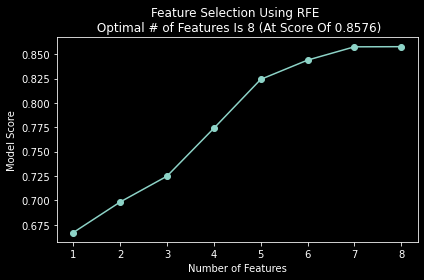

In [17]:
# feature selection

# instantiate regression and feature selecter object
regressor = LinearRegression()
feature_selector = RFECV(regressor)

# learn relationships
fit = feature_selector.fit(X_train, y_train)

# determine optimal number of features based on cross validation
optimal_feature_count = feature_selector.n_features_
print(f'Optimal Number of Features: {optimal_feature_count} \n')

# create new dataframe with selected features
X_train = X_train.loc[:, feature_selector.get_support()]
X_test = X_test.loc[:, feature_selector.get_support()]

# plot results to visually determine best number of features
plt.plot(range(1, len(fit.cv_results_['mean_test_score']) + 1), fit.cv_results_['mean_test_score'], marker = "o")
plt.ylabel("Model Score")
plt.xlabel("Number of Features")
plt.title(f"Feature Selection Using RFE \n Optimal # of Features Is {optimal_feature_count} (At Score Of {round(max(fit.cv_results_['mean_test_score']),4)})")
plt.tight_layout()
plt.show()

### Model Training

In [18]:
# train model
regressor = LinearRegression()
regressor.fit(X_train, y_train)

LinearRegression()

In [19]:
# predict on the test set
y_pred = regressor.predict(X_test)
y_pred

array([ 0.1652103 ,  0.41210025,  0.64060589,  0.5459636 ,  0.74115586,
        0.36268972,  0.23269686, -0.08571596,  0.62226474,  0.59810223,
        0.88742331,  0.3414499 ,  0.6404862 ,  0.62061618,  0.75020045,
        0.3086617 ,  0.28554165,  0.62480193,  0.53382952,  0.64520035,
        0.22888288,  0.79121225,  0.65409613,  0.40607449,  0.9865813 ,
        0.7275668 ,  0.18288998,  0.55867209,  0.62891625,  0.51866087,
        0.65195882,  0.68232127,  0.90138538,  0.72787699,  0.49531779,
        0.69914387,  0.32667578,  0.2836864 ,  0.50500707,  0.20954219,
        0.78462134, -0.01319415,  0.10376645,  0.74147802,  0.62263467,
        0.57379199,  0.37504855,  0.50460136,  0.44833014,  0.71299625,
        0.58840837,  0.67633546,  0.51590334,  0.4884633 ,  0.40401866,
        0.64061013,  0.81533655,  0.83732541,  0.06558321,  0.5478638 ,
        0.32055917,  0.60075695,  0.26458658,  0.55808759,  0.48965507,
        0.38970119,  0.56423399,  0.39410933,  0.57771985,  0.40

# Performance Assessment

In [20]:
# calculate R-Squared
r_squared = r2_score(y_test, y_pred)
print(f'R-Squared = {r_squared}')

R-Squared = 0.7889476450479233


In [21]:
# cross validation
cv = KFold(n_splits = 4, shuffle = True)
cv_scores = cross_val_score(regressor, X_train, y_train, cv = cv, scoring = 'r2')
print(f'Cross Validation Score: {cv_scores.mean()}')

Cross Validation Score: 0.8563007041265283


In [22]:
# calculate adjusted r-squared
num_data_points, num_input_vars = X_test.shape # output of .shape is the number of rows and columns
adjusted_r_squared = 1 - (1 - r_squared) * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(f'Adjusted R-Squared = {adjusted_r_squared}')

Adjusted R-Squared = 0.762971970592283


In [23]:
# extract model coefficients
coefficients = pd.DataFrame(regressor.coef_)
input_var_names = pd.DataFrame(X_train.columns)
summary_coef = pd.concat([input_var_names, coefficients], axis = 1)
summary_coef.columns = ['input_variable', 'coefficient']

summary_coef

,input_variable,coefficient
0,distance_from_store,-0.186111
1,credit_score,-0.032838
2,total_sales,0.000089
3,total_items,0.001008
4,transaction_count,-0.003814
5,product_area_count,0.071137
6,average_basket_value,-0.001767
7,gender_M,0.020617


In [24]:
# extract model intercept
intercept = regressor.intercept_
print(f'Intercept: {intercept}')

Intercept: 0.3990398114751611


The coefficient value for each of the input variables, along with that of the intercept would make up the equation for the line of best fit for this particular model (or more accurately, in this case it would be the plane of best fit, as we have multiple input variables).

For each input variable, the coefficient value we see above tells us, with *everything else staying constant* how many units the output variable (loyalty score) would change with a *one unit change* in this particular input variable.

## Decision Tree
We will again utlise the scikit-learn library within Python to model our data using a Decision Tree. The code sections below are broken up into 4 key sections:

* Data Import
* Data Preprocessing
* Model Training
* Performance Assessment
* Decision Tree Regularisation
* Decision Tree Visualization

### Data Import

In [25]:
# import libraries
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder

In [26]:
# import modelling data
data_for_model = pickle.load(open("data/customer_loyalty_modelling.p", "rb"))

# drop uneccessary columns
data_for_model.drop("customer_id", axis = 1, inplace = True)

# shuffle data
data_for_model = shuffle(data_for_model, random_state = 42)

data_for_model.head()

,distance_from_store,gender,credit_score,customer_loyalty_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
455,0.28,M,0.81,0.889,990.65,243,53,4,18.691509
621,2.58,F,0.58,0.162,333.26,70,13,4,25.635385
64,0.80,M,0.80,0.956,1753.96,371,52,5,33.730000
456,0.16,M,0.56,0.926,929.57,225,51,4,18.226863
196,3.27,F,0.67,0.297,1904.55,376,36,3,52.904167


### Data Preprocessing
While Linear Regression is susceptible to the effects of outliers, and highly correlated input variables - Decision Trees are not, so the required preprocessing here is lighter. We still however will put in place logic for:

* Missing Values
* Encoding Categorical Variables

In [27]:
# deal with missing value
print(data_for_model.isna().sum())
data_for_model = data_for_model.dropna(how = 'any') # we don't need to use imputer in this case since we have a very small amount of na records

distance_from_store       2
gender                    3
credit_score              2
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
average_basket_value      0
dtype: int64


In [28]:
# split input and output variables
X = data_for_model.drop(["customer_loyalty_score"], axis = 1)
y = data_for_model["customer_loyalty_score"]

In [29]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [30]:
# deal with categorical variables
categorical_vars = ['gender']

# enstantiate one hot encoder object and apply to training and test data
one_hot_encoder = OneHotEncoder(sparse = False, drop = 'first') # returns array, drops one of the binary categorical columns to reduce multicollinearity

X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

# create object to get feature names
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# create data frame with encoder variables and feature names, and concat to original data frame and reset index
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index (drop = True), X_train_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_train.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index (drop = True), X_test_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_test.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

### Model Training

In [31]:
# train model
regressor = DecisionTreeRegressor()
regressor.fit(X_train, y_train)

DecisionTreeRegressor()

In [32]:
# predict on the test set
y_pred = regressor.predict(X_test)
y_pred

array([0.174, 0.267, 0.302, 0.813, 0.672, 0.267, 0.366, 0.828, 0.457,
       0.36 , 0.851, 0.683, 0.457, 0.268, 0.003, 0.081, 0.657, 0.127,
       0.759, 0.667, 0.506, 0.408, 0.508, 0.706, 0.116, 0.916, 0.997,
       0.448, 0.408, 0.832, 0.272, 0.441, 0.985, 0.337, 0.66 , 0.624,
       0.796, 0.234, 0.968, 0.404, 0.728, 0.937, 0.116, 0.963, 0.988,
       0.781, 0.12 , 0.063, 0.581, 0.68 , 0.201, 0.852, 0.398, 0.162,
       0.657, 0.881, 0.297, 0.77 , 0.344, 0.65 , 0.174, 0.027, 0.498,
       0.247, 0.698, 0.208, 0.366, 0.127, 0.337, 0.754, 0.916, 0.457,
       0.265, 0.526, 0.631, 0.898, 0.036, 0.852, 0.859])

### Performance Assessment

In [33]:
# calculate R-Squared
r_squared = r2_score(y_test, y_pred)
print(f'R-Squared = {r_squared}')

R-Squared = 0.8809822761230048


In [36]:
# cross validation
cv = KFold(n_splits = 4, shuffle = True)
cv_scores = cross_val_score(regressor, X_train, y_train, cv = cv, scoring = 'r2')
print(f'Cross Validation Score: {cv_scores.mean()}')

Cross Validation Score: 0.8497162955586417


In [35]:
# calculate adjusted r-squared
num_data_points, num_input_vars = X_test.shape # output of .shape is the number of rows and columns
adjusted_r_squared = 1 - (1 - r_squared) * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(f'Adjusted R-Squared = {adjusted_r_squared}')

Adjusted R-Squared = 0.8673802505370625


### Decision Tree Regularisation
Decision Tree's can be prone to over-fitting, in other words, without any limits on their splitting, 
they will end up learning the training data perfectly.  We would much prefer our model to have a more 
*generalised* set of rules, as this will be more robust & reliable when making predictions on *new* data.

One effective method of avoiding this over-fitting, is to apply a *max depth* to the Decision Tree, 
meaning we only allow it to split the data a certain number of times before it is required to stop.

Unfortunately, we don't necessarily know the *best* number of splits to use for this - so below we will loop 
over a variety of values and assess which gives us the best predictive performance!

In [37]:
# finding best value for max_depth (maximum number of splits)
max_depth_list = list(range(1, 9))
accuracy_scores = []

for depth in max_depth_list:
    regressor = DecisionTreeRegressor(max_depth = depth)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)

    accuracy = r2_score(y_test, y_pred)
    accuracy_scores.append(accuracy)


accuracy_scores_dict = {
    'Depth_1': accuracy_scores[0],
    'Depth_2': accuracy_scores[1],
    'Depth_3': accuracy_scores[2],
    'Depth_4': accuracy_scores[3],
    'Depth_5': accuracy_scores[4],
    'Depth_6': accuracy_scores[5],
    'Depth_7': accuracy_scores[6],
    'Depth_8': accuracy_scores[7],
}

accuracy_scores_dict

{'Depth_1': 0.48041516747913704,
 'Depth_2': 0.749628862008641,
 'Depth_3': 0.8434993278383678,
 'Depth_4': 0.8666832224200037,
 'Depth_5': 0.877539761200972,
 'Depth_6': 0.9035730999342096,
 'Depth_7': 0.8894785873230003,
 'Depth_8': 0.8897876858466721}

In [38]:
# determine max accuracy and optimal depth
max_accuracy = max(accuracy_scores)
max_accuracy_idx = accuracy_scores.index(max_accuracy)
optimal_depth = max_depth_list[max_accuracy_idx]

print(f'The Optimal Depth is: {optimal_depth}')

The Optimal Depth is: 6


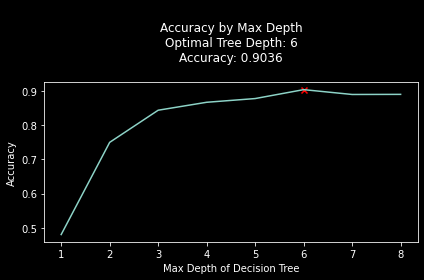

In [39]:
# plot of max depths
plt.plot(max_depth_list, accuracy_scores)
plt.scatter(optimal_depth, max_accuracy, marker = 'x', color = 'red')

plt.title(f'''
Accuracy by Max Depth
Optimal Tree Depth: {optimal_depth}
Accuracy: {round(max_accuracy, 4)}
''')

plt.xlabel('Max Depth of Decision Tree')
plt.ylabel('Accuracy')

plt.tight_layout()
plt.show()

In [40]:
# re-train model with determined max depth
regressor_re_train = DecisionTreeRegressor(max_depth = 4) # less than the most accurate depth, attempt to keep decision tree smaller
regressor_re_train.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4)

In [41]:
# predict on the test set using re-trained model
y_pred_re_train = regressor_re_train.predict(X_test)
y_pred_re_train

array([0.26066667, 0.32832558, 0.26066667, 0.65457143, 0.65457143,
       0.32832558, 0.4645    , 0.828     , 0.335     , 0.4645    ,
       0.90407143, 0.79628571, 0.335     , 0.26066667, 0.04257143,
       0.04257143, 0.50694444, 0.12183333, 0.79628571, 0.65457143,
       0.4645    , 0.65457143, 0.50694444, 0.79628571, 0.12183333,
       0.907     , 0.90407143, 0.4645    , 0.65457143, 0.79628571,
       0.32832558, 0.50694444, 0.90407143, 0.335     , 0.79628571,
       0.65457143, 0.74157143, 0.26066667, 0.90407143, 0.32832558,
       0.65457143, 0.90407143, 0.12183333, 0.79628571, 0.90407143,
       0.79628571, 0.26066667, 0.04257143, 0.55466667, 0.55466667,
       0.26066667, 0.79628571, 0.4645    , 0.12183333, 0.50694444,
       0.90407143, 0.32832558, 0.79628571, 0.55466667, 0.79628571,
       0.26066667, 0.04257143, 0.50694444, 0.32832558, 0.79628571,
       0.32832558, 0.4645    , 0.12183333, 0.335     , 0.65457143,
       0.907     , 0.335     , 0.32832558, 0.50694444, 0.65457

In [42]:
# calculate new R-Squared
r_squared_re_train = r2_score(y_test, y_pred_re_train)
print(f'R-Squared = {r_squared_re_train}')

R-Squared = 0.8666832224200036


In [43]:
# calculate new adjusted r-squared
adjusted_r_squared_re_train = 1 - (1 - r_squared_re_train) * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(f'Adjusted R-Squared = {adjusted_r_squared_re_train}')

Adjusted R-Squared = 0.851447019268004


In the plot we can see that the *maximum* classification accuracy on the test set is found when applying a *max_depth* value of 7.  
However, we lose very little accuracy back to a value of 4, but this would result in a simpler model, that generalised even better on new data.  
We make the executive decision to re-train our Decision Tree with a maximum depth of 4.

R Squared and Adjusted R Squared dropped a few points due to the reduction of overfitting.

### Visualise Our Decision Tree
To see the decisions that have been made in the (re-fitted) tree, we can use the plot_tree functionality 
that we imported from scikit-learn. To do this, we use the below code:

[Text(0.5, 0.9, 'distance_from_store <= 1.975\nsquared_error = 0.088\nsamples = 315\nvalue = 0.511'),
 Text(0.25, 0.7, 'distance_from_store <= 0.975\nsquared_error = 0.044\nsamples = 177\nvalue = 0.703'),
 Text(0.125, 0.5, 'total_sales <= 197.0\nsquared_error = 0.022\nsamples = 113\nvalue = 0.799'),
 Text(0.0625, 0.3, 'distance_from_store <= 0.33\nsquared_error = 0.018\nsamples = 22\nvalue = 0.602'),
 Text(0.03125, 0.1, 'squared_error = 0.003\nsamples = 7\nvalue = 0.742'),
 Text(0.09375, 0.1, 'squared_error = 0.011\nsamples = 15\nvalue = 0.537'),
 Text(0.1875, 0.3, 'credit_score <= 1498.465\nsquared_error = 0.011\nsamples = 91\nvalue = 0.846'),
 Text(0.15625, 0.1, 'squared_error = 0.01\nsamples = 49\nvalue = 0.796'),
 Text(0.21875, 0.1, 'squared_error = 0.007\nsamples = 42\nvalue = 0.904'),
 Text(0.375, 0.5, 'credit_score <= 1605.05\nsquared_error = 0.038\nsamples = 64\nvalue = 0.533'),
 Text(0.3125, 0.3, 'total_sales <= 211.5\nsquared_error = 0.017\nsamples = 38\nvalue = 0.416'),
 Tex

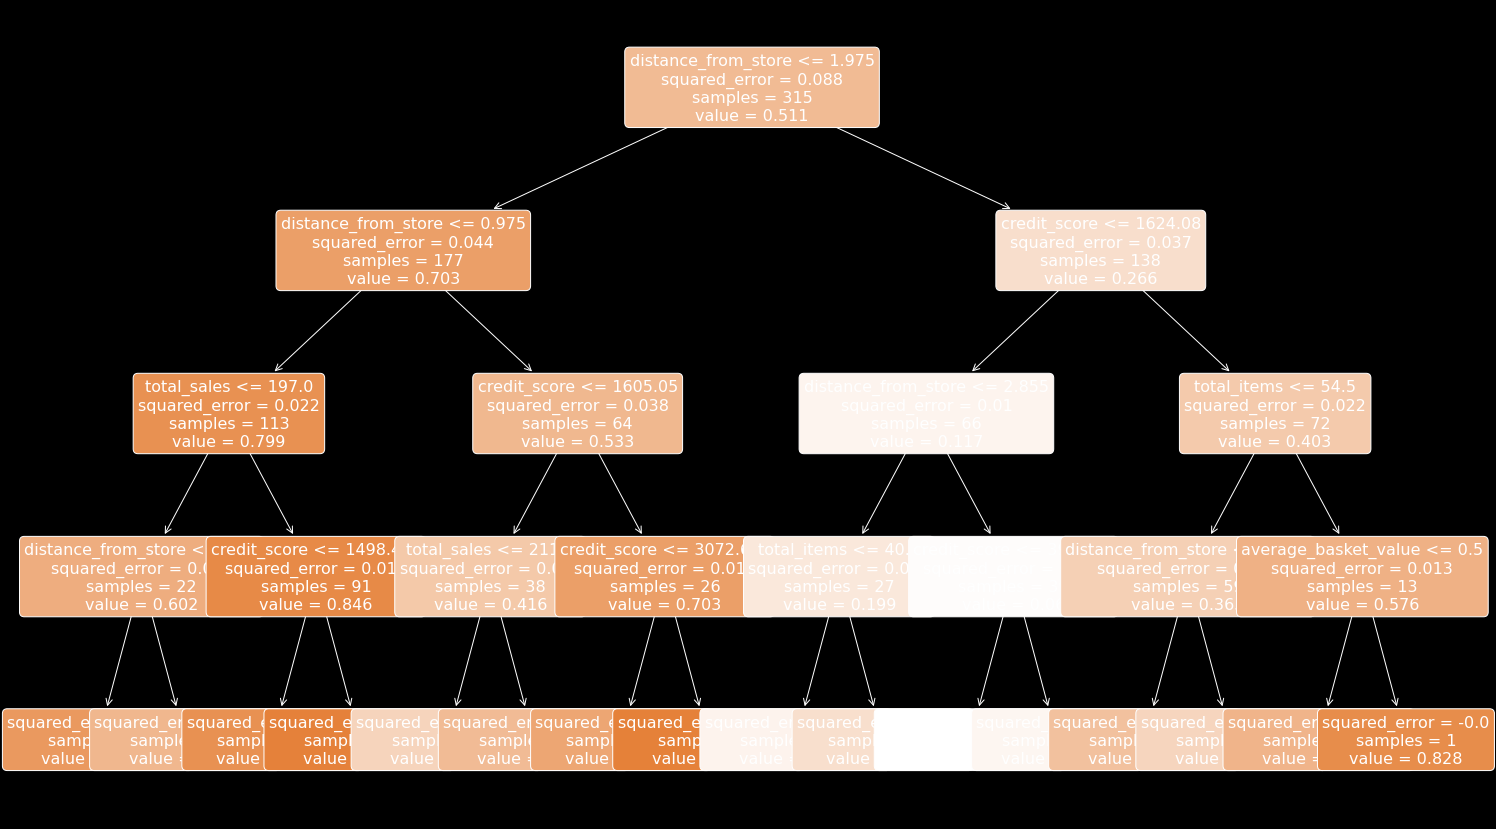

In [44]:
# plot decission tree
plt.figure(figsize = (25, 15))
tree = plot_tree(
    regressor_re_train,
    feature_names = X.columns,
    filled = True,
    rounded = True,
    fontsize = 16
)

tree

This is a very powerful visual, and one that can be shown to stakeholders in the business to ensure they understand exactly what is driving the predictions.

One interesting thing to note is that the *very first split* appears to be using the variable *distance from store* so it would seem that this is a very important variable when it comes to predicting loyalty!

# Random Forest
We will again utlise the scikit-learn library within Python to model our data using a Random Forest. The code sections below are broken up into 4 key sections:

* Data Import
* Data Preprocessing
* Model Training
* Performance Assessment
* Feature Importance

### Data Import

In [45]:
# import libraries
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.inspection import permutation_importance

In [46]:
# import modelling data
data_for_model = pickle.load(open("data/customer_loyalty_modelling.p", "rb"))

# drop uneccessary columns
data_for_model.drop("customer_id", axis = 1, inplace = True)

# shuffle data
data_for_model = shuffle(data_for_model, random_state = 42)

### Data Preprocessing
While Linear Regression is susceptible to the effects of outliers, and highly correlated input variables - Decision Trees are not, so the required preprocessing here is lighter. We still however will put in place logic for:

* Missing Values
* Encoding Categorical Variables

In [48]:
# deal with missing value
print(data_for_model.isna().sum())
data_for_model = data_for_model.dropna(how = 'any') # we don't need to use imputer in this case since we have a very small amount of na records

distance_from_store       2
gender                    3
credit_score              2
customer_loyalty_score    0
total_sales               0
total_items               0
transaction_count         0
product_area_count        0
average_basket_value      0
dtype: int64


In [49]:
# split input and output variables
X = data_for_model.drop(["customer_loyalty_score"], axis = 1)
y = data_for_model["customer_loyalty_score"]

In [50]:
# split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [51]:
# deal with categorical variables
categorical_vars = ['gender']

# enstantiate one hot encoder object and apply to training and test data
one_hot_encoder = OneHotEncoder(sparse = False, drop = 'first') # returns array, drops one of the binary categorical columns to reduce multicollinearity

X_train_encoded = one_hot_encoder.fit_transform(X_train[categorical_vars])
X_test_encoded = one_hot_encoder.transform(X_test[categorical_vars])

# create object to get feature names
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

# create data frame with encoder variables and feature names, and concat to original data frame and reset index
X_train_encoded = pd.DataFrame(X_train_encoded, columns = encoder_feature_names)
X_train = pd.concat([X_train.reset_index (drop = True), X_train_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_train.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

X_test_encoded = pd.DataFrame(X_test_encoded, columns = encoder_feature_names)
X_test = pd.concat([X_test.reset_index (drop = True), X_test_encoded.reset_index (drop = True)], axis = 1) # axis 1 concats columns and not rows
X_test.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows

### Model Training

In [52]:
# train model
regressor = RandomForestRegressor(random_state = 42)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [53]:
# predict on the test set
y_pred = regressor.predict(X_test)

### Performance Assessment

In [54]:
# calculate R-Squared
r_squared = r2_score(y_test, y_pred)
print(f'R-Squared = {r_squared}')

R-Squared = 0.9598627943571644


In [55]:
# cross validation
cv = KFold(n_splits = 4, shuffle = True)
cv_scores = cross_val_score(regressor, X_train, y_train, cv = cv, scoring = 'r2')
print(f'Cross Validation Score: {cv_scores.mean()}')

Cross Validation Score: 0.9242052081468748


In [56]:
# calculate adjusted r-squared
num_data_points, num_input_vars = X_test.shape # output of .shape is the number of rows and columns
adjusted_r_squared = 1 - (1 - r_squared) * (num_data_points - 1) / (num_data_points - num_input_vars - 1)
print(f'Adjusted R-Squared = {adjusted_r_squared}')

Adjusted R-Squared = 0.9552756851408403


### Feature Importance
In our Linear Regression model, to understand the relationships between input variables and our ouput variable, loyalty score, we examined the coefficients.  With our Decision Tree we looked at what the earlier splits were.  These allowed us some insight into which input variables were having the most impact.

Random Forests are an ensemble model, made up of many Decision Trees, each of which is different due to the randomness of the data being provided, and the random selection of input variables available at each potential split point.

Because of this, we end up with a powerful and robust model, but because of the random or different nature of all these Decision trees - the model gives us a unique insight into how important each of our input variables are to the overall model.  

As we’re using random samples of data, and input variables for each Decision Tree - there are many scenarios where certain input variables are being held back and this enables us a way to compare how accurate the models predictions are if that variable is or isn’t present.

So, at a high level, in a Random Forest we can measure *importance* by asking *How much would accuracy decrease if a specific input variable was removed or randomised?*

If this decrease in performance, or accuracy, is large, then we’d deem that input variable to be quite important, and if we see only a small decrease in accuracy, then we’d conclude that the variable is of less importance.

There are two common ways to tackle this.  The first, often just called **Feature Importance** is where we find all nodes in the Decision Trees of the forest where a particular input variable is used to split the data and assess what the Mean Squared Error (for a Regression problem) was before the split was made, and compare this to the Mean Squared Error after the split was made.  We can take the *average* of these improvements across all Decision Trees in the Random Forest to get a score that tells us *how much better* we’re making the model by using that input variable.

If we do this for *each* of our input variables, we can compare these scores and understand which is adding the most value to the predictive power of the model!

The other approach, often called **Permutation Importance** cleverly uses some data that has gone *unused* at when random samples are selected for each Decision Tree (this stage is called "bootstrap sampling" or "bootstrapping")

These observations that were not randomly selected for each Decision Tree are known as *Out of Bag* observations and these can be used for testing the accuracy of each particular Decision Tree.

For each Decision Tree, all of the *Out of Bag* observations are gathered and then passed through.  Once all of these observations have been run through the Decision Tree, we obtain an accuracy score for these predictions, which in the case of a regression problem could be Mean Squared Error or r-squared.

In order to understand the *importance*, we *randomise* the values within one of the input variables - a process that essentially destroys any relationship that might exist between that input variable and the output variable - and run that updated data through the Decision Tree again, obtaining a second accuracy score.  The difference between the original accuracy and the new accuracy gives us a view on how important that particular variable is for predicting the output.

*Permutation Importance* is often preferred over *Feature Importance* which can at times inflate the importance of numerical features. Both are useful, and in most cases will give fairly similar results.

Let's put them both in place, and plot the results...

In [57]:
# feature importance summary
feature_importance = pd.DataFrame(regressor.feature_importances_)
feature_names = pd.DataFrame(X.columns)

feature_importance_summary = pd.concat([feature_names, feature_importance], axis = 1)
feature_importance_summary.columns = ['input_variable', 'feature_importance']
feature_importance_summary.sort_values(by = 'feature_importance', inplace = True)

feature_importance_summary

,input_variable,feature_importance
7,average_basket_value,0.009975
1,gender,0.010667
6,product_area_count,0.021749
4,total_items,0.025743
5,transaction_count,0.040706
3,total_sales,0.097606
2,credit_score,0.113845
0,distance_from_store,0.679708


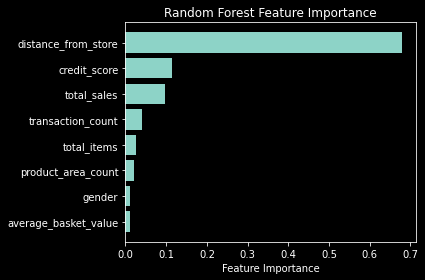

In [58]:
# feature importance bar plot
plt.barh(
    feature_importance_summary['input_variable'],
    feature_importance_summary['feature_importance']
)

plt.title("Random Forest Feature Importance")
plt.xlabel('Feature Importance')
plt.tight_layout()

plt.show()

In [59]:
# permutation importance (decrease in model performance when particular features are randomly shuffled)
# this is another form of feature importance
permutation_result = permutation_importance(regressor, X_test, y_test, n_repeats = 10) # n_repeats number of times random shuffling is applied
permutation_result

{'importances_mean': array([1.48933414e+00, 8.56691295e-04, 1.13477699e-01, 1.35018612e-01,
        1.57352273e-02, 4.23130625e-02, 8.73095259e-03, 6.56652933e-03]),
 'importances_std': array([0.12924887, 0.00113098, 0.01765377, 0.02316721, 0.00503745,
        0.00882078, 0.00262676, 0.00193935]),
 'importances': array([[ 1.45531636e+00,  1.36264417e+00,  1.43348174e+00,
          1.67182069e+00,  1.57175656e+00,  1.34431514e+00,
          1.64730937e+00,  1.32504670e+00,  1.65988650e+00,
          1.42176418e+00],
        [ 2.71202488e-04,  6.86845462e-05, -5.91107485e-04,
          2.00208717e-03,  9.72065216e-04,  1.12334640e-03,
          5.59115864e-04,  5.15264223e-04,  5.36752379e-05,
          3.59257929e-03],
        [ 1.26216231e-01,  1.23925534e-01,  1.31898261e-01,
          1.35962496e-01,  1.05858197e-01,  9.57423576e-02,
          7.45130738e-02,  1.12657361e-01,  1.21356412e-01,
          1.06647065e-01],
        [ 1.34783213e-01,  1.81839760e-01,  1.40012095e-01,
     

In [60]:
# permutation importance summary
permutation_importance = pd.DataFrame(permutation_result['importances_mean']) # average importance result for each input variable
feature_names = pd.DataFrame(X.columns)

permutation_importance_summary = pd.concat([feature_names, permutation_importance], axis = 1)
permutation_importance_summary.columns = ['input_variable', 'permutation_importance']
permutation_importance_summary.sort_values(by = 'permutation_importance', inplace = True)

permutation_importance_summary

,input_variable,permutation_importance
1,gender,0.000857
7,average_basket_value,0.006567
6,product_area_count,0.008731
4,total_items,0.015735
5,transaction_count,0.042313
2,credit_score,0.113478
3,total_sales,0.135019
0,distance_from_store,1.489334


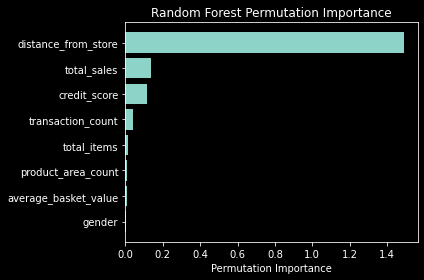

In [61]:
# permutation importance bar plot
plt.barh(
    permutation_importance_summary['input_variable'],
    permutation_importance_summary['permutation_importance']
)

plt.title("Random Forest Permutation Importance")
plt.xlabel('Permutation Importance')
plt.tight_layout()

plt.show()

The overall story from both approaches is very similar. The most important or impactful input variable is *distance_from_store* which is the same insights we derived when assessing our Linear Regression & Decision Tree models.

There are slight differences in the order or "importance" for the remaining variables but overall they have provided similar findings.

In [63]:
# save objects to predict loyalty scores for customers that the agency could not match
pickle.dump(regressor, open('data/random_forest_regression_model.p', 'wb'))
pickle.dump(one_hot_encoder, open('data/random_forest_regression_model_ohe.p', 'wb'))

# Predicting Missing Loyalty Scores
We have selected the model to use (Random Forest) and now we need to make the *loyalty_score* predictions for those customers that the market research consultancy were unable to tag.

We cannot just pass the data for these customers into the model, as is - we need to ensure the data is in exactly the same format as what was used when training the model.

In the following code, we will

* Import the required packages for preprocessing
* Import the data for those customers who are missing a *loyalty_score* value
* Import our model object & any preprocessing artifacts
* Drop columns that were not used when training the model (customer_id)
* Drop rows with missing values
* Apply One Hot Encoding to the gender column (using transform)
* Make the predictions using .predict()

In [62]:
# import customers for scoring
to_be_scored = pickle.load(open('data/customer_loyalty_scoring.p', 'rb'))
to_be_scored.head()

,customer_id,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
6,1,4.78,F,0.66,3980.49,424,51,5,78.048824
7,120,3.49,F,0.38,2887.20,253,45,5,64.160000
8,52,14.91,F,0.68,3342.75,335,47,5,71.122340
10,435,0.25,M,0.62,2326.71,267,48,5,48.473125
12,679,4.74,F,0.58,3448.59,370,49,5,70.379388


In [64]:
# import model and model objects
regressor = pickle.load(open('data/random_forest_regression_model.p', 'rb'))
one_hot_encoder = pickle.load(open('data/random_forest_regression_model_ohe.p', 'rb'))

In [65]:
# drop unused column (customer_id)
to_be_scored.drop(['customer_id'], axis = 1, inplace = True)
to_be_scored.head()

,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value
6,4.78,F,0.66,3980.49,424,51,5,78.048824
7,3.49,F,0.38,2887.20,253,45,5,64.160000
8,14.91,F,0.68,3342.75,335,47,5,71.122340
10,0.25,M,0.62,2326.71,267,48,5,48.473125
12,4.74,F,0.58,3448.59,370,49,5,70.379388


In [66]:
# drop missing values
to_be_scored.dropna(how = 'any', inplace = True)
to_be_scored.isna().sum()

distance_from_store     0
gender                  0
credit_score            0
total_sales             0
total_items             0
transaction_count       0
product_area_count      0
average_basket_value    0
dtype: int64

In [67]:
# add columns to apply one hot encoding into a list
categorical_vars = ['gender']

In [68]:
# apply one hot encoder object
encoder_vars_array = one_hot_encoder.transform(to_be_scored[categorical_vars])

In [70]:
# create object to get feature names
encoder_feature_names = one_hot_encoder.get_feature_names_out(categorical_vars)

In [71]:
# create data frame with encoder variables and feature names
encoder_vars_df = pd.DataFrame(encoder_vars_array, columns = encoder_feature_names)
encoder_vars_df.tail()

,gender_M
458,0.0
459,1.0
460,1.0
461,0.0
462,1.0


In [72]:
# concat new dataframe to original resetting index (ensures no rows are misaligned)
to_be_scored = pd.concat([
    to_be_scored.reset_index(drop = True), 
    encoder_vars_df.reset_index(drop = True)], 
    axis = 1) # axis 1 concats columns and not rows
    
to_be_scored.tail()

,distance_from_store,gender,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
458,400.97,F,0.54,4072.86,346,45,5,90.508000,0.0
459,0.32,M,0.38,3097.99,281,51,5,60.744902,1.0
460,1.62,M,0.63,3736.02,250,46,5,81.217826,1.0
461,4.36,F,0.54,4407.12,354,47,5,93.768511,0.0
462,1.87,M,0.59,3067.83,254,53,5,57.883585,1.0


In [73]:
# drop original categorical columns
to_be_scored.drop(categorical_vars, axis = 1, inplace = True) # axis 1 drops columns and not rows
to_be_scored.tail()

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M
458,400.97,0.54,4072.86,346,45,5,90.508000,0.0
459,0.32,0.38,3097.99,281,51,5,60.744902,1.0
460,1.62,0.63,3736.02,250,46,5,81.217826,1.0
461,4.36,0.54,4407.12,354,47,5,93.768511,0.0
462,1.87,0.59,3067.83,254,53,5,57.883585,1.0


In [74]:
# make our predictions
loyalty_predictions = regressor.predict(to_be_scored)
loyalty_predictions

array([0.42641, 0.32992, 0.34719, 0.93166, 0.3849 , 0.93566, 0.43343,
       0.73502, 0.31208, 0.74406, 0.43255, 0.51648, 0.44943, 0.49396,
       0.51378, 0.35195, 0.79852, 0.27749, 0.9132 , 0.39764, 0.28666,
       0.57642, 0.45266, 0.30921, 0.6539 , 0.42941, 0.5505 , 0.90092,
       0.5734 , 0.32631, 0.35492, 0.41621, 0.47523, 0.56345, 0.67158,
       0.34009, 0.33038, 0.89301, 0.36622, 0.44413, 0.85157, 0.72539,
       0.45002, 0.93642, 0.94507, 0.22433, 0.39676, 0.96111, 0.53929,
       0.44196, 0.8682 , 0.86839, 0.73586, 0.29151, 0.60416, 0.84114,
       0.23933, 0.3014 , 0.24201, 0.24305, 0.24934, 0.87329, 0.86826,
       0.55587, 0.39386, 0.57611, 0.92211, 0.41034, 0.9446 , 0.25769,
       0.61682, 0.45259, 0.64507, 0.49405, 0.62185, 0.39843, 0.16508,
       0.61596, 0.7924 , 0.54604, 0.28182, 0.29235, 0.30199, 0.71632,
       0.56894, 0.2379 , 0.36931, 0.28792, 0.40425, 0.37513, 0.39393,
       0.90329, 0.91231, 0.26916, 0.38641, 0.38063, 0.87808, 0.53341,
       0.31401, 0.92

In [75]:
loyalty_predictions_df = pd.DataFrame(loyalty_predictions)
loyalty_predictions_df.columns = ['loyalty_prediction']

scored = pd.concat([
    to_be_scored.reset_index (drop = True),
    loyalty_predictions_df.reset_index(drop = True)],
    axis = 1
)

scored

,distance_from_store,credit_score,total_sales,total_items,transaction_count,product_area_count,average_basket_value,gender_M,loyalty_prediction
0,4.78,0.66,3980.49,424,51,5,78.048824,0.0,0.42641
1,3.49,0.38,2887.20,253,45,5,64.160000,0.0,0.32992
2,14.91,0.68,3342.75,335,47,5,71.122340,0.0,0.34719
3,0.25,0.62,2326.71,267,48,5,48.473125,1.0,0.93166
4,4.74,0.58,3448.59,370,49,5,70.379388,0.0,0.38490
...,...,...,...,...,...,...,...,...,...
458,400.97,0.54,4072.86,346,45,5,90.508000,0.0,0.36794
459,0.32,0.38,3097.99,281,51,5,60.744902,1.0,0.92925
460,1.62,0.63,3736.02,250,46,5,81.217826,1.0,0.67320
461,4.36,0.54,4407.12,354,47,5,93.768511,0.0,0.36973
